<a href="https://colab.research.google.com/github/Vaishnavi-Chandrashekar/CC-FRAUD-DETECTION/blob/main/Modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#importing common libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from warnings import filterwarnings

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
df = pd.read_csv('/content/drive/MyDrive/new_df.csv')

# Identifying outliers

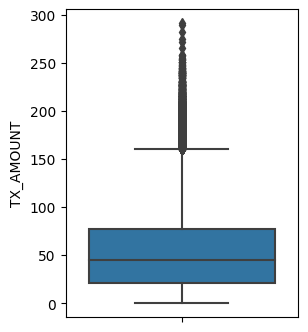

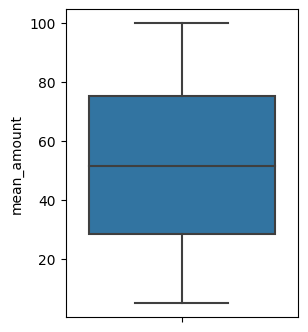

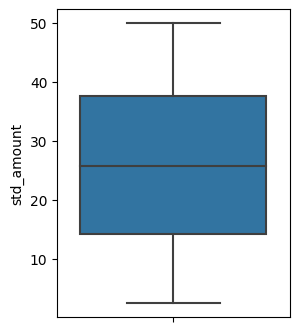

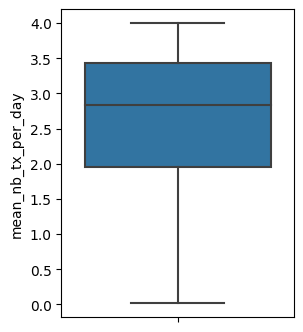

In [ ]:
column_names = ['TX_AMOUNT','mean_amount','std_amount','mean_nb_tx_per_day']
def identify_outliers(give_df_name, give_column_name):
    for i in column_names:
        fig = plt.figure(figsize=(3,4))
        sns.boxplot(data = df, y = i)
plt.show()

identify_outliers(df, column_names)

Q1 = 21.13 Q2 =  44.77 Q3 =  76.85
upper 160.43
lower -62.45


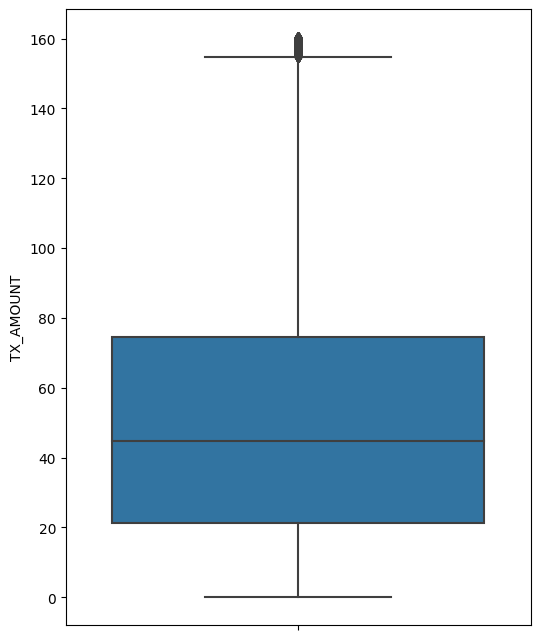

In [ ]:
#treating the TX_AMOUNT column using the IQR method
Q1 = np.percentile(df['TX_AMOUNT'], 25)
Q2 = np.percentile(df['TX_AMOUNT'], 50)
Q3 = np.percentile(df['TX_AMOUNT'], 75)
IQR = Q3 - Q1        
print('Q1 =',Q1,'Q2 = ',Q2,'Q3 = ',Q3)

upper_val = Q3 + (1.5 * IQR)
print('upper', upper_val)
lower_val = Q1 - (1.5 * IQR)
print('lower', lower_val)

df.loc[df['TX_AMOUNT'] > upper_val, 'TX_AMOUNT'] = np.median(df['TX_AMOUNT'])
df.loc[df['TX_AMOUNT'] < lower_val, 'TX_AMOUNT'] = np.median(df['TX_AMOUNT'])
        
fig = plt.figure(figsize = (6,8))
sns.boxplot(data = df,y = 'TX_AMOUNT')
plt.xticks(rotation = 'horizontal')
plt.show()

#correlation

<ipython-input-6-e13a76b71afb>:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), cmap="crest", annot = True, fmt = '.0%')


<Axes: >

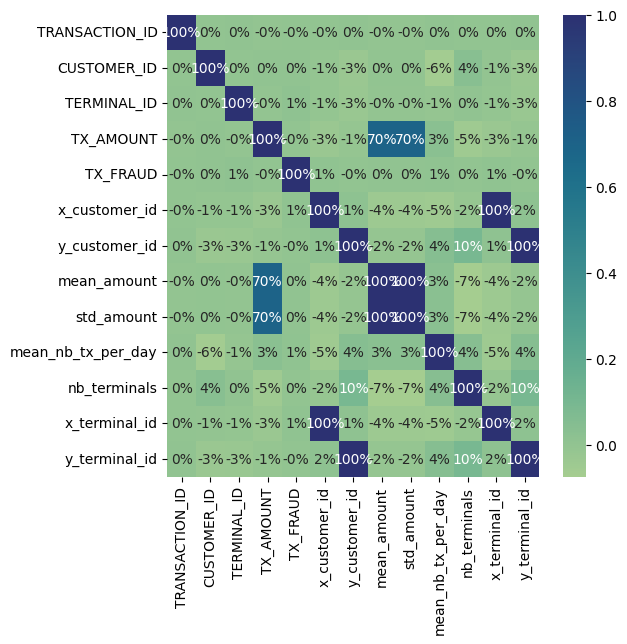

In [ ]:
plt.figure(figsize=(6,6))
sns.heatmap(df.corr(), cmap="crest", annot = True, fmt = '.0%')

Let's drop x_terminal_id and y_terminal_id as it is correlation with x_customer_id and y_customer_id

In [ ]:
df = df.drop(['x_terminal_id','y_terminal_id'], axis=True)

In [ ]:
df.columns

Index(['TRANSACTION_ID', 'TX_DATETIME', 'CUSTOMER_ID', 'TERMINAL_ID',
       'TX_AMOUNT', 'TX_FRAUD', 'x_customer_id', 'y_customer_id',
       'mean_amount', 'std_amount', 'mean_nb_tx_per_day',
       'available_terminals', 'nb_terminals'],
      dtype='object')

In [ ]:
df = df.drop(['TX_DATETIME','available_terminals'], axis=1)

#Modeling

# Handling the imbalanced data

In [ ]:
import random
df1 = df.sample(40000)
df1.shape

(40000, 11)

In [ ]:
#seperating the x and y variables
X1 = df1.drop('TX_FRAUD', axis = 1) #independent features  

y1 = df1['TX_FRAUD'] #dependent features

In [ ]:
#train_test split
from sklearn.model_selection import train_test_split
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size = 0.3, random_state = 0)
print(X1_train.shape, y1_train.shape, X1_test.shape, y1_test.shape)

(28000, 10) (28000,) (12000, 10) (12000,)


## Smote - over sampling

In [ ]:
# applying smote to handle imbalance in the target variable
from imblearn.over_sampling import SMOTE
from collections import Counter

print('Classes and number of values in trainset before SMOTE:',Counter(y1_train),'\n')

oversample = SMOTE()
X1_sample,y1_sample = oversample.fit_resample(X1_train,y1_train)
print('Classes and number of values in trainset after SMOTE:',Counter(y1_sample),'\n')

Classes and number of values in trainset before SMOTE: Counter({0: 27384, 1: 616}) 

Classes and number of values in trainset after SMOTE: Counter({0: 27384, 1: 27384}) 



## undersampling

In [ ]:
df2 = df.copy()
#seperating the x and y variables
X2 = df2.drop('TX_FRAUD', axis = 1) #independent features  

y2 = df2['TX_FRAUD'] #dependent features

In [ ]:
#train_test split
from sklearn.model_selection import train_test_split
X2_train, X2_test, y2_train, y2_test = train_test_split(X2, y2, test_size = 0.3, random_state = 0)
print(X2_train.shape, y2_train.shape, X2_test.shape, y2_test.shape)

(203861, 10) (203861,) (87370, 10) (87370,)


In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
# Implementing Undersampling for Handling Imbalanced 
nm = NearMiss()
X_res,y_res=nm.fit_resample(X2_train,y2_train)
X_res.shape, y_res.shape

((9212, 10), (9212,))

In [ ]:
from collections import Counter
print('Original dataset shape{}'.format(Counter(y2_train)))
print('Resampled dataset shape{}'.format(Counter(y_res)))

Original dataset shapeCounter({0: 199255, 1: 4606})
Resampled dataset shapeCounter({0: 4606, 1: 4606})


## buliding the models

In [ ]:
from sklearn.model_selection import RepeatedKFold, cross_validate, train_test_split

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from sklearn.svm import SVC
import time

In [ ]:
algorithms = {
    'DT': DecisionTreeClassifier(random_state=0),
    'LR': LogisticRegression(random_state=0, max_iter=500),
    'KNN': KNeighborsClassifier(),
    'GauNB': GaussianNB(),
    'BerNB': BernoulliNB(),
    'RF': RandomForestClassifier(random_state=0),
    'XGB': XGBClassifier(random_state=0),
    'GradB': GradientBoostingClassifier(random_state=0),
    'LGBM': LGBMClassifier(random_state=0),
    'SVC': SVC(random_state=0),
}

In [ ]:
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, roc_auc_score

scoring = {
    'precision': make_scorer(precision_score, average='weighted', zero_division=0),
    'recall': make_scorer(recall_score, average='weighted', zero_division=0),
    'f1': make_scorer(f1_score, average='weighted', zero_division=0),
    'roc_auc': make_scorer(roc_auc_score, average='weighted', multi_class='ovr')
}

In [ ]:
def test_algorithms(X,y):
  result = pd.DataFrame()
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
    
  for key, algorithm in algorithms.items():
    start_time = time.time()
    print(f'{key}...', end = '')
    model = algorithm

    cv_results = cross_validate(model, X, y, cv=cv, scoring=scoring, return_estimator =True)

    new_row = {
        'Algorithm': key,
        'precision': round(np.mean(cv_results['test_precision']), 5),
        'recall': round(np.mean(cv_results['test_recall']), 5),
        'f1': round(np.mean(cv_results['test_f1']), 5),
        'roc_auc': round(np.mean(cv_results['test_roc_auc']), 5),
        'run_time': round((time.time() - start_time) / 60, 2),
        'model': cv_results['estimator'][0]
      }
    result = pd.concat([result, pd.Series(new_row)], axis=1)
    print(f'finished!!! {round((time.time() - start_time) / 60, 2)} min(s).')
  return result.transpose().sort_values(by='f1', ascending=False)

In [ ]:
result_oversampling = test_algorithms(X1_sample, y1_sample)

DT...finished!!! 0.24 min(s).
LR...finished!!! 0.1 min(s).
KNN...finished!!! 0.11 min(s).
GauNB...finished!!! 0.01 min(s).
BerNB...finished!!! 0.01 min(s).
RF...finished!!! 4.94 min(s).
XGB...finished!!! 2.34 min(s).
GradB...finished!!! 4.23 min(s).
LGBM...finished!!! 0.2 min(s).
SVC...finished!!! 36.27 min(s).


In [ ]:
result_undersampling = test_algorithms(X_res, y_res)

DT...finished!!! 0.03 min(s).
LR...finished!!! 0.01 min(s).
KNN...finished!!! 0.02 min(s).
GauNB...finished!!! 0.0 min(s).
BerNB...finished!!! 0.0 min(s).
RF...finished!!! 0.64 min(s).
XGB...finished!!! 0.29 min(s).
GradB...finished!!! 0.51 min(s).
LGBM...finished!!! 0.07 min(s).
SVC...finished!!! 0.93 min(s).


In [ ]:
result_oversampling['Method'] = 'Oversampling'
result_undersampling['Method'] = 'Undersampling'

result = pd.concat([result_oversampling, result_undersampling], axis=0)

In [ ]:
metrics = ['precision', 'recall', 'f1', 'roc_auc']
result['mean_metrics'] = result[metrics].mean(axis=1)

In [ ]:
#result.set_index([ 'Method', 'Algorithm' ]).sort_values(by='precision', ascending=False).drop('model', axis=1)
result.set_index([ 'Method', 'Algorithm' ]).drop('model', axis=1)

precision   recall       f1  roc_auc run_time  \
Method        Algorithm                                                 
Oversampling  RF           0.9872  0.98716  0.98716  0.98717     4.94   
              XGB         0.95387  0.95331   0.9533  0.95333     2.34   
              DT          0.94584  0.94581  0.94581  0.94582     0.24   
              LGBM        0.88754  0.88434  0.88411  0.88438      0.2   
              KNN         0.87713  0.86066  0.85912  0.86065     0.11   
              GradB       0.76827    0.764  0.76307  0.76403     4.23   
              GauNB       0.64727  0.64335  0.64103  0.64339     0.01   
              LR          0.53675  0.53654  0.53637  0.53664      0.1   
              SVC         0.53401  0.53385  0.53378  0.53393    36.27   
              BerNB       0.58131  0.49616  0.32966  0.50052     0.01   
Undersampling XGB         0.81587  0.81528  0.81521   0.8153     0.29   
              RF          0.81318  0.81119  0.81091  0.81124     0.64   
              LGBM        0.78397  0.78362  0.78361  0.78376     0.07   
              DT          0.74069  0.73936  0.73906  0.73941     0.03   
              GradB       0.66501  0.66015  0.65784   0.6604     0.51   
              KNN         0.65672  0.63566  0.62308  0.63572     0.02   
              GauNB       0.56437  0.56242  0.55991  0.56284      0.0   
              LR          0.51375  0.51216  0.50953  0.51306     0.01   
              SVC          0.4665  0.49747  0.45072  0.50119     0.93   
              BerNB       0.39525  0.49284  0.32577  0.50014      0.0   

                         mean_metrics  
Method        Algorithm                
Oversampling  RF             0.987173  
              XGB            0.953453  
              DT             0.945820  
              LGBM           0.885093  
              KNN            0.864390  
              GradB          0.764842  
              GauNB          0.643760  
              LR             0.536575  
              SVC            0.533893  
              BerNB          0.476912  
Undersampling XGB            0.815415  
              RF             0.811630  
              LGBM           0.783740  
              DT             0.739630  
              GradB          0.660850  
              KNN            0.637795  
              GauNB          0.562385  
              LR             0.512125  
              SVC            0.478970  
              BerNB          0.428500

In [ ]:
df.head()

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,nb_terminals
0,59383,323,217,4.60,0,84.515409,38.276422,7.353061,3.676530,3.324124,19
1,59384,6,429,8.61,0,11.827443,63.992102,18.618562,9.309281,3.778676,16
2,59385,714,1011,64.00,0,75.221083,94.991427,82.620413,41.310207,3.723765,13
3,59386,266,1969,12.72,0,51.122179,8.329098,9.852171,4.926085,3.862067,15
4,59387,890,1482,98.88,0,62.777887,31.405270,83.660035,41.830018,3.128315,20


In [ ]:
df1

,TRANSACTION_ID,CUSTOMER_ID,TERMINAL_ID,TX_AMOUNT,TX_FRAUD,x_customer_id,y_customer_id,mean_amount,std_amount,mean_nb_tx_per_day,nb_terminals
2310,61693,483,923,11.55,0,38.165375,88.552264,19.063675,9.531837,3.295960,13
89866,149249,36,817,28.30,0,80.619399,70.388858,14.521554,7.260777,3.677930,12
250236,309619,193,1029,135.33,0,21.645726,16.604782,92.661878,46.330939,1.176307,17
199338,258721,633,658,88.34,0,66.218365,58.099582,87.612135,43.806067,3.973621,17
68932,128315,382,849,9.79,0,42.837851,92.315902,14.983996,7.491998,3.930296,16
...,...,...,...,...,...,...,...,...,...,...,...
60237,119620,89,1014,59.31,0,27.759610,12.886057,42.304189,21.152095,3.825623,22
48628,108011,181,1346,96.96,0,39.256879,87.837250,70.624554,35.312277,3.949395,11
254020,313403,613,773,35.40,1,86.758085,31.309888,59.776532,29.888266,1.706286,15
233588,292971,568,1897,33.08,0,89.486974,17.628164,31.569486,15.784743,2.326719,13


# Hyper parameter tuning

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
def hyper_parameter_tunning(X, y, model, parameter_space):
  start_time = time.time()
  cv = RepeatedKFold(n_splits=5, n_repeats=3, random_state=0)
  clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=cv, scoring='f1')
  clf.fit(X, y)
  print(f'finished!!! {round((time.time() - start_time) / 60, 2)} min(s).')
  # Best paramete set
  print('Best parameters found:\n', clf.best_params_)

## Random Forest

In [ ]:
algorithms['RF']

RandomForestClassifier(random_state=0)

In [ ]:
rf_params = {
    'n_estimators': [100, 200, 500],
    'max_features': ['sqrt', 'log2'],
    'max_depth': [4, 6, 8],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'class_weight': ['balanced', {0:1, 1:2}, {0:1, 1:3}]
}

In [ ]:
hyper_parameter_tunning(X, y, algorithms['RF'], rf_params)

## LGBM

In [ ]:
algorithms['LGBM']

In [ ]:
lgbm_params = params_lgbm = {
    'boosting_type': ['gbdt'],
    'num_leaves': [31, 50, 100],
    'max_depth': [-1, 10, 20],
    'learning_rate': [0.01, 0.1, 0.5],
    'n_estimators': [50, 100, 200],
    'min_child_samples': [20, 50, 100],
    'class_weight': [{0: 1, 1: w} for w in [1, 5, 10, 20, 50]]
}

In [ ]:
hyper_parameter_tunning(X, y, algorithms['LGBM'], lgbm_params)

## XGB Undersampled

In [ ]:
algorithms['XGB']

In [ ]:
xgb_params = {
    'learning_rate': [0.01, 0.1],
    'n_estimators': [100, 500, 1000],
    'max_depth': [3, 5, 7],
    'gamma': [0, 0.1, 0.5],
    'subsample': [0.5, 0.8, 1.0],
    'colsample_bytree': [0.5, 0.8, 1.0],
    'scale_pos_weight': [492/9348],
    'eval_metric': ['aucpr']
}